In [235]:
import pandas as pd
import numpy as np
import joblib
import time
from tqdm import tqdm
import threading

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor

#!pip install lightgbm
from lightgbm import LGBMRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.inspection import permutation_importance

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV



In [236]:
df = pd.read_csv('csv_files/sales.csv')


In [237]:
df01 = pd.read_csv('csv_files/ironkaggle_notarget.csv')

In [238]:
df01

,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,State_holiday,School_holiday
0,7,764,4,2013-12-26,0,0,0,c,1
1,19,22,3,2013-05-22,449,1,0,0,1
2,31,1087,6,2013-06-29,622,1,0,0,0
3,45,139,6,2013-08-17,314,1,0,0,0
4,56,568,1,2014-04-07,356,1,0,0,0
...,...,...,...,...,...,...,...,...,...
71200,712004,217,2,2015-01-13,633,1,1,0,0
71201,712018,604,3,2014-04-30,743,1,1,0,0
71202,712020,1021,5,2014-07-18,1852,1,1,0,1
71203,712023,28,3,2014-08-27,0,0,0,0,1


## ML Training


### Ordinal

In [239]:
df['State_holiday'].unique()

array(['0', 'c', 'a', 'b'], dtype=object)

In [240]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.drop(columns=['True_index'], inplace=True)
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['is_weekend'] = df['Day_of_week'] >= 5
df['is_month_start'] = df['Date'].dt.is_month_start
df['is_month_end'] = df['Date'].dt.is_month_end
df.drop(columns=['Date'], inplace=True)
df['state_holiday'] = df['State_holiday'].map({'0': 0, 'c': 1, 'a': 2, 'b': 3})
df.drop(columns=['State_holiday'], inplace=True)
df.columns = df.columns.str.lower()

In [241]:
df

,store_id,day_of_week,nb_customers_on_day,open,promotion,school_holiday,sales,year,month,day,is_weekend,is_month_start,is_month_end,state_holiday
0,625,3,641,1,1,0,7293,2013,11,6,False,False,False,0
1,293,2,877,1,1,1,7060,2013,7,16,False,False,False,0
2,39,4,561,1,1,0,4565,2014,1,23,False,False,False,0
3,676,4,1584,1,1,0,6380,2013,9,26,False,False,False,0
4,709,3,1477,1,1,0,11647,2014,1,22,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640835,674,6,611,1,0,0,4702,2014,9,20,True,False,False,0
640836,1014,4,1267,1,1,0,12545,2015,1,15,False,False,False,0
640837,135,6,595,1,0,0,5823,2015,6,20,True,False,False,0
640838,810,1,599,1,1,1,7986,2014,8,18,False,False,False,0


In [242]:
df01

,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,State_holiday,School_holiday
0,7,764,4,2013-12-26,0,0,0,c,1
1,19,22,3,2013-05-22,449,1,0,0,1
2,31,1087,6,2013-06-29,622,1,0,0,0
3,45,139,6,2013-08-17,314,1,0,0,0
4,56,568,1,2014-04-07,356,1,0,0,0
...,...,...,...,...,...,...,...,...,...
71200,712004,217,2,2015-01-13,633,1,1,0,0
71201,712018,604,3,2014-04-30,743,1,1,0,0
71202,712020,1021,5,2014-07-18,1852,1,1,0,1
71203,712023,28,3,2014-08-27,0,0,0,0,1


#### Random Forest

In [243]:
"""
features = df.drop(columns = ["sales"])
target = df["sales"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)
normalizer = StandardScaler()
normalizer.fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
model_rf01 = RandomForestRegressor(n_estimators=100,
                             max_depth=20)
#model_rf01.fit(X_train_norm, y_train)
#joblib.dump(model_rf01, 'models/model_rf01.pkl')
model_rf01 = joblib.load('models/model_rf01.pkl')
pred = model_rf01.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", model_rf01.score(X_test_norm, y_test))
"""

'\nfeatures = df.drop(columns = ["sales"])\ntarget = df["sales"]\nX_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)\nnormalizer = StandardScaler()\nnormalizer.fit(X_train)\nX_train_norm = normalizer.transform(X_train)\nX_test_norm = normalizer.transform(X_test)\nX_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)\nX_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)\nmodel_rf01 = RandomForestRegressor(n_estimators=100,\n                             max_depth=20)\n#model_rf01.fit(X_train_norm, y_train)\n#joblib.dump(model_rf01, \'models/model_rf01.pkl\')\nmodel_rf01 = joblib.load(\'models/model_rf01.pkl\')\npred = model_rf01.predict(X_test_norm)\n\nprint("MAE", mean_absolute_error(pred, y_test))\nprint("RMSE", mean_squared_error(pred, y_test, squared=False))\nprint("R2 score", model_rf01.score(X_test_norm, y_test))\n'

In [244]:
features = df.drop(columns = ["sales"])
target = df["sales"]

In [245]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)
normalizer = StandardScaler()
normalizer.fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

In [246]:
model_rf01 = RandomForestRegressor(n_estimators=100,
                             max_depth=20)

In [247]:
#model_rf01.fit(X_train_norm, y_train)

In [248]:
#joblib.dump(model_rf01, 'models/model_rf01.pkl')

In [249]:
model_rf01 = joblib.load('models/model_rf01.pkl')

In [250]:
pred = model_rf01.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", model_rf01.score(X_test_norm, y_test))

MAE 627.815433398502
RMSE 961.0244888959523


c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R2 score 0.9380034173566567


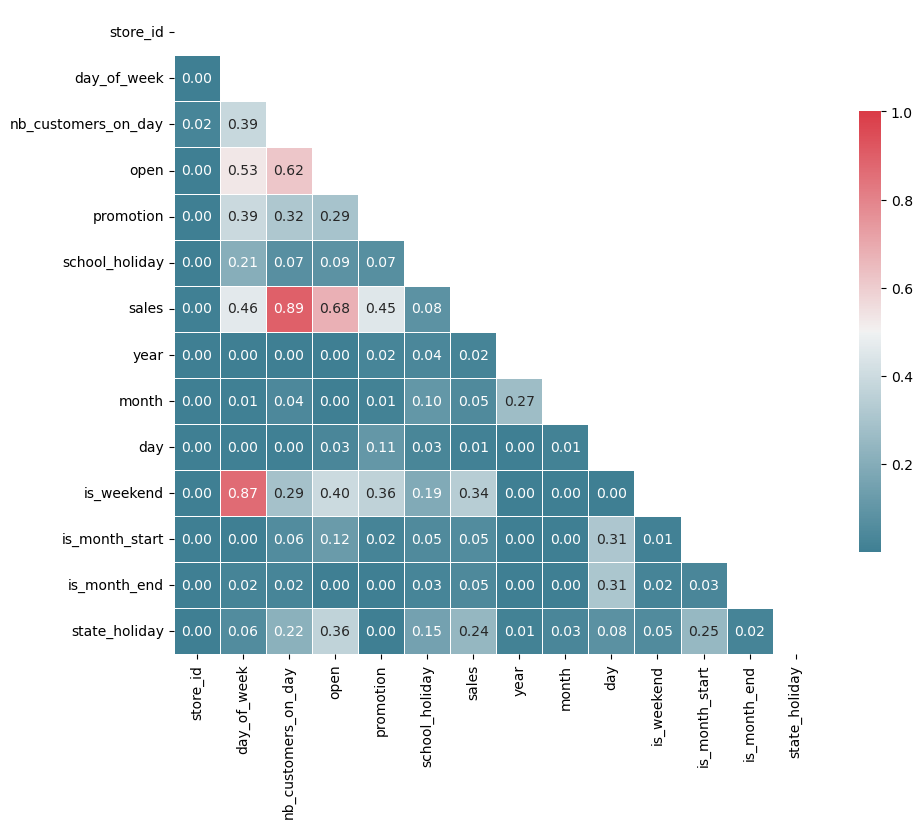

In [251]:
corr=np.abs(df.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .5},
    annot=True,  # Show numbers
    fmt=".2f",  # Format numbers to 2 decimals
    annot_kws={"size": 10, "ha": 'center', "va": 'center'}  # Style annotations
)
plt.tight_layout()
plt.show()

Check columns importance

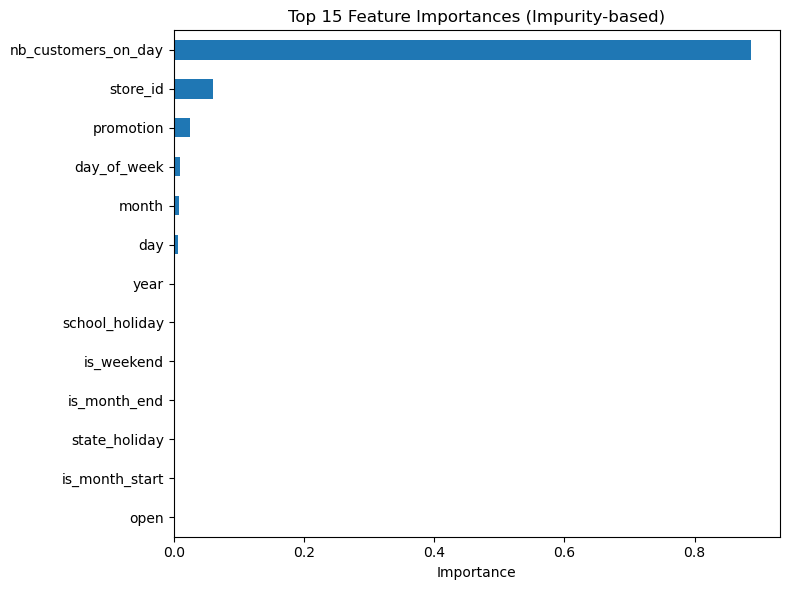

In [252]:
# — Assume `model` is already trained, and X_train is defined —

# 1. Extract the raw importances
importances = model_rf01.feature_importances_

# 2. Create a pandas Series (index = feature names), sorted descending
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# 3. Plot the top 15
plt.figure(figsize=(8, 6))
feat_importance.plot(kind='barh')
plt.title("Top 15 Feature Importances (Impurity-based)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [253]:
features = df.drop(columns = ["sales", 'open', 'is_weekend','school_holiday','year'])
target = df["sales"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

normalizer = StandardScaler()

normalizer.fit(X_train)

X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

model_rf02 = RandomForestRegressor(n_estimators=100,
                             max_depth=None)

#model_rf02.fit(X_train_norm, y_train)
#joblib.dump(model_rf02, 'models/model_rf02.pkl')

model_rf02 = joblib.load('models/model_rf02.pkl')
pred = model_rf02.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", model_rf02.score(X_test_norm, y_test))

MAE 497.814511032395
RMSE 821.1346896357047


c:\Users\estif\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R2 score 0.9547386356124814


In [254]:
#### Failed Halving Grid Search Attempt
"""



# ------------------------------
# 1. Prepare Features and Target
# ------------------------------
# (Assume `df` is already loaded in your environment)
features = df.drop(columns=["sales", "open", "is_weekend", "school_holiday", "year"])
target = df["sales"]

# ------------------------------
# 2. Train/Test Split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.20, random_state=0
)

# ------------------------------
# 3. Normalize Features
# ------------------------------
normalizer = StandardScaler()
normalizer.fit(X_train)

# When converting back to DataFrame, keep the original indices
X_train_norm = pd.DataFrame(
    normalizer.transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_norm = pd.DataFrame(
    normalizer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# ------------------------------
# 4. Define a Focused Parameter Grid
# ------------------------------
param_grid_focused = {
    "n_estimators": [100, 200, 300],   # number of trees
    "max_depth": [None, 15, 20, 25],   # tree depth around 20
    "max_features": ["sqrt", 0.5],     # sqrt(#features) or 50% of features
    "min_samples_split": [3, 5, 7],    # min samples to split
    "min_samples_leaf": [1, 2, 3]      # min samples at leaf
}

# ------------------------------
# 5. Quick Mini‐Run to Estimate Total Time
# ------------------------------
# We'll run HalvingGridSearchCV on 30% of the data with 3‐fold CV,
# then scale that elapsed time up to estimate the full run (5‐fold, 100% of data).

small_frac = 0.3
X_small = X_train_norm.sample(frac=small_frac, random_state=42)
y_small = y_train.loc[X_small.index]

# Count how many hyperparameter combinations we have in the full grid
full_param_list = list(ParameterGrid(param_grid_focused))
n_candidates_full = len(full_param_list)
n_splits_full = 5  # because the final run will use 5‐fold CV

# Time a “mini‐run” with 3‐fold CV on 30% of training data
start = time.time()
halving_test = HalvingGridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_focused,
    cv=3,                      # fewer folds for speed in mini‐run
    factor=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42
)
halving_test.fit(X_small, y_small)
elapsed_small = time.time() - start

# Extrapolate elapsed_small → full run time estimate:
#   elapsed_small seconds covered: 
#     • 30% of training data 
#     • 3‐fold CV 
# We need to scale to:
#     • 100% of data 
#     • 5‐fold CV
estimated_seconds = int(elapsed_small * (n_splits_full / 3) * (1 / small_frac))
print(f"Estimated total time for full HalvingGridSearchCV: {estimated_seconds} seconds\n")

# ------------------------------
# 6. Configure Full HalvingGridSearchCV
# ------------------------------
halving_search = HalvingGridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_focused,
    cv=5,                            # full run uses 5-fold CV
    factor=3,                        # drop 2/3 of candidates each iteration
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2,                       # detailed per-iteration logging
    random_state=42
)

# ------------------------------
# 7. Fit in Background + Show tqdm Progress Bar
# ------------------------------
def fit_halving():
    halving_search.fit(X_train_norm, y_train)

# Launch fitting in a separate thread
fit_thread = threading.Thread(target=fit_halving)
fit_thread.start()

# Display tqdm bar for estimated_seconds
with tqdm(total=estimated_seconds, desc="HalvingGridSearchCV", unit="s") as pbar:
    while fit_thread.is_alive():
        time.sleep(1)
        pbar.update(1)

# Ensure the thread finishes
fit_thread.join()
print("\n✅ HalvingGridSearchCV fitting complete.\n")

# ------------------------------
# 8. Retrieve Best Estimator & Parameters
# ------------------------------
best_rf = halving_search.best_estimator_
print("Best hyperparameters found by HalvingGridSearchCV:")
print(halving_search.best_params_)
best_cv_rmse = np.sqrt(-halving_search.best_score_)
print(f"Best CV RMSE (5-fold): {best_cv_rmse:.2f}\n")

# ------------------------------
# 9. Save the Best Model
# ------------------------------
joblib.dump(best_rf, "models/best_rf_halving.pkl")

# ------------------------------
# 10. Load & Evaluate on Test Set
# ------------------------------
loaded_rf = joblib.load("models/best_rf_halving.pkl")
y_pred = loaded_rf.predict(X_test_norm)

print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R² score:", r2_score(y_test, y_pred))
"""

'\n\n\n\n# ------------------------------\n# 1. Prepare Features and Target\n# ------------------------------\n# (Assume `df` is already loaded in your environment)\nfeatures = df.drop(columns=["sales", "open", "is_weekend", "school_holiday", "year"])\ntarget = df["sales"]\n\n# ------------------------------\n# 2. Train/Test Split\n# ------------------------------\nX_train, X_test, y_train, y_test = train_test_split(\n    features, target, test_size=0.20, random_state=0\n)\n\n# ------------------------------\n# 3. Normalize Features\n# ------------------------------\nnormalizer = StandardScaler()\nnormalizer.fit(X_train)\n\n# When converting back to DataFrame, keep the original indices\nX_train_norm = pd.DataFrame(\n    normalizer.transform(X_train),\n    columns=X_train.columns,\n    index=X_train.index\n)\nX_test_norm = pd.DataFrame(\n    normalizer.transform(X_test),\n    columns=X_test.columns,\n    index=X_test.index\n)\n\n# ------------------------------\n# 4. Define a Focused Pa

Grid Search Random Forest


In [255]:
#### Failed Grid Search Attempt
""""

features = df.drop(columns=["sales", "open", "is_weekend", "school_holiday", "year"])
target = df["sales"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)
normalizer = StandardScaler()
normalizer.fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True], # Standard Random Forest uses bootstrapping
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.0, 0.001, 0.01],
    'max_samples': [0.7, 0.9, None] # Relevant if bootstrap=True
}

model_rf03 = RandomForestRegressor()

model_grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(),              # your base model (e.g. RandomForestClassifier)
    param_grid=param_grid, # param grid with all possible combinations (no distributions)
    cv=5,                           # 5-fold cross-validation
    n_jobs=-1,                     # use all processors
    scoring='f1',                   # scoring metric for classification
    refit=True,                    # refit best estimator on whole dataset
    verbose=1                      # optional: to see progress
)

#model_rf03.fit(X_train_norm, y_train)
#joblib.dump(model_rf03, 'models/model_rf03.pkl')
model_rf03 = joblib.load('models/model_rf03.pkl')
pred = model_rf03.predict(X_test_norm)
print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", model_rf03.score(X_test_norm, y_test))

"""

'"\n\nfeatures = df.drop(columns=["sales", "open", "is_weekend", "school_holiday", "year"])\ntarget = df["sales"]\n\nX_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)\nnormalizer = StandardScaler()\nnormalizer.fit(X_train)\nX_train_norm = normalizer.transform(X_train)\nX_test_norm = normalizer.transform(X_test)\nX_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)\nX_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)\n\nparam_grid = {\n    \'n_estimators\': [100, 200],\n    \'max_features\': [\'sqrt\', \'log2\'],\n    \'max_depth\': [10, 20, None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'bootstrap\': [True], # Standard Random Forest uses bootstrapping\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'ccp_alpha\': [0.0, 0.001, 0.01],\n    \'max_samples\': [0.7, 0.9, None] # Relevant if bootstrap=True\n}\n\nmodel_rf03 = RandomForestRegressor()\n\nmodel_grid_se

### Predict

In [256]:
df01['Date'] = pd.to_datetime(df01['Date'], errors='coerce')
df01.drop(columns=['True_index'], inplace=True)
df01['year'] = df01['Date'].dt.year
df01['month'] = df01['Date'].dt.month
df01['day'] = df01['Date'].dt.day
df01['is_weekend'] = df01['Day_of_week'] >= 5
df01['is_month_start'] = df01['Date'].dt.is_month_start
df01['is_month_end'] = df01['Date'].dt.is_month_end
df01.drop(columns=['Date'], inplace=True)
df01['state_holiday'] = df01['State_holiday'].map({'0': 0, 'c': 1, 'a': 2, 'b': 3})
df01.drop(columns=['State_holiday'], inplace=True)
df01.columns = df01.columns.str.lower()

In [257]:
features_df01 = df01.drop(columns=["open", "is_weekend", "school_holiday", "year"])

scaler = StandardScaler()

X_df01_norm = normalizer.transform(features_df01)

X_df01_norm = pd.DataFrame(
    X_df01_norm,
    columns=features_df01.columns,
    index=features_df01.index
)

model_rf02 = joblib.load("models/model_rf02.pkl")

y_pred_df01 = model_rf02.predict(X_df01_norm)

df01["predicted_sales"] = y_pred_df01

df01.to_csv("df01_with_predictions.csv", index=False)
print("Done. Predictions stored in df01['predicted_sales'] and saved to df01_with_predictions.csv.")


Done. Predictions stored in df01['predicted_sales'] and saved to df01_with_predictions.csv.


In [ ]:
df0

,store_id,day_of_week,nb_customers_on_day,open,promotion,school_holiday,year,month,day,is_weekend,is_month_start,is_month_end,state_holiday,predicted_sales
0,764,4,0,0,0,1,2013,12,26,False,False,False,1,0.00
1,22,3,449,1,0,1,2013,5,22,False,False,False,0,3504.70
2,1087,6,622,1,0,0,2013,6,29,True,False,False,0,6511.37
3,139,6,314,1,0,0,2013,8,17,True,False,False,0,3798.12
4,568,1,356,1,0,0,2014,4,7,False,False,False,0,3800.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71200,217,2,633,1,1,0,2015,1,13,False,False,False,0,5456.46
71201,604,3,743,1,1,0,2014,4,30,False,False,True,0,7685.33
71202,1021,5,1852,1,1,1,2014,7,18,True,False,False,0,16191.32
71203,28,3,0,0,0,1,2014,8,27,False,False,False,0,0.00


In [259]:
ironkaggle_solutions = pd.read_csv('csv_files/ironkaggle_solutions.csv')

In [260]:
ironkaggle_solutions

,True_index,Sales
0,7,0.000000
1,19,3792.528564
2,31,5999.958008
3,45,3365.519287
4,56,3458.130127
...,...,...
71200,712004,5714.028320
71201,712018,9701.739258
71202,712020,15175.256836
71203,712023,0.000000
